In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from tensor import Tensor
from layers import Initializers, Dense
from models import Sequential
from optim import WarmUpAndDecayScheduler
import losses, metrics

![image](https://miro.medium.com/v2/resize:fit:1400/1*J-v2B6T9RKxdvwThtQ1NVg.png)

# Derivatives and Chain Rule

$$\frac{d}{dx} f(x) = \lim_{{h \to 0}} \frac{f(x+h) - f(x)}{h}$$

👉 Indicate that how $f(x)$ changes if we keep increasing $x$ a little bit $h$?:
- If the result > 0, $f(x)$ will go up if we keep doing that ⬆️.
- If the result < 0, $f(x)$ will go down if we keep doing that ⬇️.


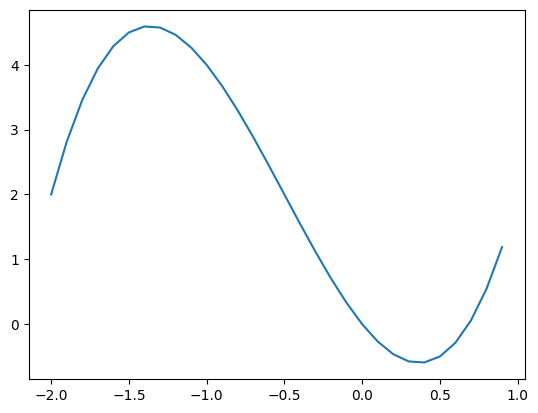

In [ ]:
def cubic_func(x):
    return 2*x**3 + 3*x**2 - 3*x

xs = np.arange(-2, 1, 0.1)
ys = cubic_func(xs)
plt.plot(xs, ys)
plt.show()

In [ ]:
h = 1e-8
x = 1.0
dx = (cubic_func(x + h) - cubic_func(x)) / h
print(
    f"df/dx = {dx:.7f} {'>' if dx > 0 else '<'} 0, meaning that if we keep increasing x by small"
    f" amount (follow derivative's direction), f(x) will {'increase' if dx > 0 else 'decrease'}."
    f"\n=> Based on this idea, Gradient Descent will update its x (weights)"
    f" in the opposite direction to minimize its f(x) (loss function)"
)

df/dx = 8.9999999 > 0, meaning that if we keep increasing x by small amount (follow derivative's direction), f(x) will increase.
=> Based on this idea, Gradient Descent will update its x (weights) in the opposite direction to minimize its f(x) (loss function)


<table>
  <tr>
    <td>

But for example, given $y = (3x + 2)^5$, how to calculate $\frac{dy}{dx}$ 🤔?

1. First, let's simplify $y$ by using $u = 3x + 2 \rightarrow y = u^5$.

2. Now, **Chain rule** said: $\frac{dy}{dx} = \frac{dy}{du} \cdot \frac{du}{dx}$.

3. It's quite simple to calculate $\frac{dy}{du} = 5u^4$ and $\frac{du}{dx} = 3$.

4. Therefore: $\frac{dy}{dx} = 5u^4 \cdot 3 = 15(3x + 2)^4$

5. The same idea is applied to calculate $\frac{dLoss}{dweight}$ 👉

    </td>
    <td>
        <img src="https://user-images.githubusercontent.com/50880271/266297834-4d943e88-2f27-4fcf-8388-45c2855ea663.png" />
    </td>
  </tr>
</table>

[As put by George F. Simmons](https://en.wikipedia.org/wiki/Chain_rule): "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

# Auto Differentiation with `Tensor` Class

### Backward Testing

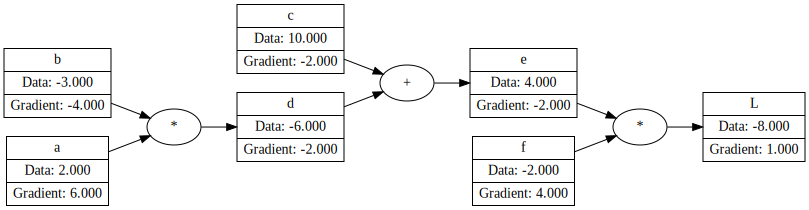

In [ ]:
# L = e * f
# => dL/de = (L(x + h) - L(x)) / h
#          = ((e + h) * f - e * f) / h
#          = (e * f + h * f - e * f) / h
#          = (h * f) / h
#          = f = -2.0
# => dL/df = (L(x + h) - L(x)) / h
#          = (e * (f + h) - e * f) / h
#          = (e * f + e * h - e * f) / h
#          = e = 4.0

# L = (c + d) * f
# => dL/dc = dL/dd = (L(x + h) - L(x)) / h
#                  = ((c + d + h) * f - (c + d) * f) / h
#                  = (c * f + d * f + h * f - c * f - d * f) / h
#                  = (h * f) / h
#                  = f = -2.0
#
# Chain rule:
# e = c + d => de/dc = de/dd = (e(x + h) - e(x)) / h
#                            = ((c + d + h) - (c + d)) / h
#                            = h / h = 1.0
# => dL/dc = dL/de * de/dc = f * 1.0 = -2.0
# => dL/dd = dL/de * de/dd = f * 1.0 = -2.0

# L = (a * b + c) * f
# => dL/da = (L(x + h) - L(x)) / h
#          = ((a + h) * b + c) * f - (a * b + c) * f / h
#          = (a * b + h * b + c) * f - (a * b + c) * f / h
#          = (h * b) * f / h
#          = b * f = -3.0 * -2.0 = 6.0
# => dL/db = (L(x + h) - L(x)) / h
#          = (a * (b + h) + c) * f - (a * b + c) * f / h
#          = (a * b + a * h + c) * f - (a * b + c) * f / h
#          = (a * h) * f / h
#          = a * f = 2.0 * -2.0 = -4.0
#
# Chain rule:
# d = a * b => dd/da = (d(x + h) - d(x)) / h
#                    = ((a + h) * b - a * b) / h
#                    = (a * b + h * b - a * b) / h
#                    = b = -3.0
#           => dd/db = (d(x + h) - d(x)) / h
#                    = (a * (b + h) - a * b) / h
#                    = (a * b + a * h - a * b) / h
#                    = a = 2.0
# dL/da = dL/dd * dd/da = f * b = -2.0 * -3.0 = 6.0
# dL/db = dL/dd * dd/db = f * a = -2.0 * 2.0 = -4.0

a = Tensor(2.0, label='a')
b = Tensor(-3.0, label='b')
c = Tensor(10.0, label='c')

d = a * b; d.label = 'd'
e = c + d; e.label = 'e'
f = Tensor(-2.0, label='f')
L = e * f; L.label = 'L'

L.backward() # L = (a * b + c) * f
L.draw_computation_graph()

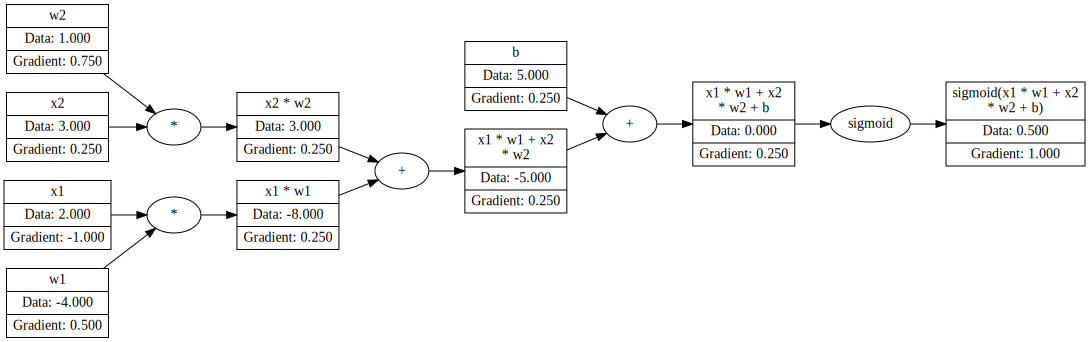

In [ ]:
x1, x2 = Tensor(2.0, 'x1'), Tensor(3.0, 'x2') # Inputs
w1, w2 = Tensor(-4.0, 'w1'), Tensor(1.0, 'w2') # Weights
b = Tensor(5.0, 'b') # Bias

x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1_plus_x2w2 = x1w1 + x2w2
y = x1w1_plus_x2w2 + b
z = y.sigmoid()

z.backward()
z.draw_computation_graph()

In [ ]:
# Compare the same computation in TensorFlow
x1, x2 = tf.Variable(2.0, name='x1'), tf.Variable(3.0, name='x2')
w1, w2 = tf.Variable(-4.0, name='w1'), tf.Variable(1.0, name='w2')
b = tf.Variable(5.0, name='b')

with tf.GradientTape() as tape:
    z = tf.nn.sigmoid(x1 * w1 + x2 * w2 + b)

gradients = tape.gradient(z, [x1, x2, w1, w2, b])
for var, grad in zip([x1, x2, w1, w2, b], gradients):
    print(f"[{var.name.split(':')[0]}] Data: {var.numpy()}, Gradient: {grad.numpy()}")

[x1] Data: 2.0, Gradient: -1.0
[x2] Data: 3.0, Gradient: 0.25
[w1] Data: -4.0, Gradient: 0.5
[w2] Data: 1.0, Gradient: 0.75
[b] Data: 5.0, Gradient: 0.25


### 🤔 What happens if not using the **Chain rule**?

 I will try to calculate this $\frac{\partial{L}}{\partial{w}}$ 👇 **without chain rule**, where $L$ is loss function of a simple Logistic Regression model with binary cross-entropy.

 ![](https://global.discourse-cdn.com/dlai/original/3X/c/9/c957632c4a117392673bf62c8e7266ba52d96f5a.png)


I know the following is not practical but I just want to strengthen my understanding by looking for a pure substitution method.

⏳ These short equations took me 3 hours to achieve.

$$\eqalign{
L &= -[y * ln(\frac{1}{1 + e^{-(wx+b)}}) + (1 - y) * ln(1 - \frac{1}{1 + e^{-(wx+b)}})] \\
  &= -[y * ln(\frac{1}{1 + e^{-(wx+b)}}) + (1 - y) * ln(\frac{e^{-(wx+b)}}{1 + e^{-(wx+b)}})] \\
}$$

Now, we used the fact that $ln(\frac{1}{1 + e^{-z}}) = -ln(1 + e^{-z})$ and $ln(\frac{e^{-z}}{1 + e^{-z}}) = -z - ln(1 + e^{-z})$, where $z = wx+b$:

$$\eqalign{
L &= -[-y * ln(1 + e^{-(wx+b)}) + (1 - y) * (-(wx+b) - ln(1 + e^{-(wx+b)}))] \\
  &= -[-y * ln(1 + e^{-(wx+b)}) - (1 - y) * ln(1 + e^{-(wx+b)}) - (1 - y) * (wx+b)] \\
  &= ln(1 + e^{-(wx+b)}) + (1 - y) * wx + (1 - y) * b] \\
}$$

Now, find $\frac{\partial{L}}{\partial{w}}$:

$$\eqalign{
\frac{\partial{L}}{\partial{w}} &= \frac{-x * e^{-(wx+b)}}{1 + e^{-(wx+b)}} + (1 - y) * x] \\
  &= \frac{-x * e^{-(wx+b)} + (1 - y) * x * (1 + e^{-(wx+b)})}{1 + e^{-(wx+b)}} \\
  &= \frac{-x * e^{-(wx+b)} + (1 - y) * x + (1 - y) * x * e^{-(wx+b)}}{1 + e^{-(wx+b)}} \\
  &= \frac{-xy * e^{-(wx+b)} + x - xy}{1 + e^{-(wx+b)}} \\
  &= \frac{-xy * (1 + e^{-(wx+b)}) + x}{1 + e^{-(wx+b)}} \\
  &= -xy + \frac{x}{1 + e^{-(wx+b)}} \\
  &= (\frac{1}{1 + e^{-(wx+b)}} - y) * x \\
  &= (sigmoid(z) - y) * x
}$$

One note here is that this [Bernoulli∗
 cross-entropy loss](https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary) is a special case of categorical cross-entropy loss for $m=2$.

$$\eqalign{
\mathcal{L}(\theta)
&= -\frac{1}{n}\sum_{i=1}^n\sum_{j=1}^m y_{ij}\log(p_{ij}) \\
&= -\frac{1}{n}\sum_{i=1}^n \left[y_i \log(p_i) + (1-y_i) \log(1-p_i)\right]
}$$

# Sequential Model (like `TensorFlow`)

<table>
  <tr>
    <td>
        <video width="100%" controls autoplay loop>
            <source src="https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2017/neural-networks/pixels-to-neurons.mp4">
        </video>
    </td>
    <td>
        <img src="https://3b1b-posts.us-east-1.linodeobjects.com/content/lessons/2017/gradient-descent/weights-and-biases.png" />
    </td>
  </tr>
  <tr>
    <td>
        <img src="https://media.licdn.com/dms/image/D4D12AQElGrpg2NiisQ/article-cover_image-shrink_600_2000/0/1707688084849?e=2147483647&v=beta&t=iBiIxGUrle6a1mlTadU-0vWvyVjCxW7DBa5qXqK_Qa4" />
    </td>
    <td>
        <img src="https://raw.githubusercontent.com/greyhatguy007/Machine-Learning-Specialization-Coursera/1a6b6fc2851e6ab2d44f86b84db316a82a70e494/C1%20-%20Supervised%20Machine%20Learning%20-%20Regression%20and%20Classification/week1/Optional%20Labs/images/C1_W1_Lab03_lecture_slopes.PNG" />
    </td>
  </tr>
</table>

In [ ]:
inputs = [2.0, 3.0]
model = Sequential([
    Dense(2, 2, activation='relu', name='Dense0'),
    Dense(2, 1, activation='sigmoid', name='Dense1')
])
model.summary()

           Model Summary           
┏━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer  ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Dense0 │      2       │       6 │
│ Dense1 │      1       │       3 │
└────────┴──────────────┴─────────┘

Total params: 9

In [ ]:
# Compare the same computation in TensorFlow
inputs = tf.constant([2.0, 3.0], name='inputs')
model = tf.keras.Sequential([
    tf.keras.Input(shape=(2,)),
    tf.keras.layers.Dense(2, activation='relu', name='Dense0'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='Dense1')
], name='Sequential')
model.summary()

Model: "Sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense0 (Dense)                       │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

# Experiments with Different Datasets

### Approximate the cubic function $y = 2x^3 + 3x^2 - 3x$

In [ ]:
model = Sequential([
    Dense(3, 4, activation='relu', initializer=Initializers.he_uniform, name='Dense0'),
    Dense(4, 3, activation='relu', initializer=Initializers.he_uniform, name='Dense1'),
    Dense(3, 1, initializer=Initializers.he_uniform, name='Dense2')
])
model.summary()

           Model Summary           
┏━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer  ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Dense0 │      4       │      16 │
│ Dense1 │      3       │      15 │
│ Dense2 │      1       │       4 │
└────────┴──────────────┴─────────┘

Total params: 35

Mean Squared Error: 12.39359269427916
True: 2.0, Pred: -0.949532302551144, Loss: 8.699740803792652
True: 2.812000000000001, Pred: -0.949532302551144, Loss: 14.149125263135717
True: 3.456000000000002, Pred: -0.9476815741027256, Loss: 19.392411406091878
True: 3.9440000000000026, Pred: -0.8244871596981573, Loss: 22.738469792206224
True: 4.288, Pred: -0.7234346897384607, Loss: 25.11447764951403
True: 4.500000000000001, Pred: -0.7161137090634004, Loss: 27.20784222587916
True: 4.5920000000000005, Pred: -0.760335843759737, Loss: 28.647498984395263
True: 4.575999999999999, Pred: -0.7918888946394356, Loss: 28.814231185193368
True: 4.463999999999999, Pred: -0.8353810452490682, Loss: 28.083439462745094
True: 4.267999999999998, Pred: -0.9230975847150513, Loss: 26.947494134034415
True: 3.9999999999999973, Pred: -0.9809048389582109, Loss: 24.809413014757297
True: 3.6719999999999966, Pred: -1.0121823161154415, Loss: 21.941563970608588
True: 3.295999999999996, Pred: -1.0203095243236402, Loss: 18.63052

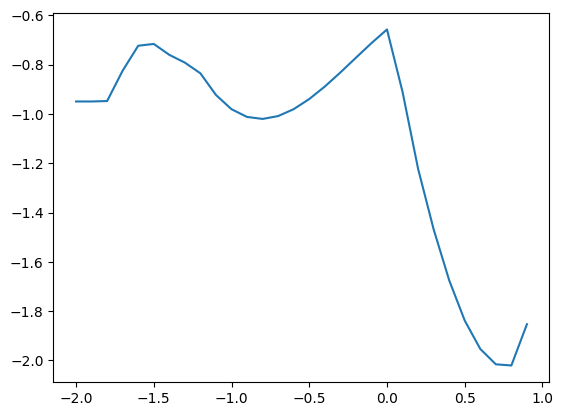

In [ ]:
X_train = [[2*x**3, 3*x**2, -3*x] for x in xs]
y_train = [cubic_func(x) for x in xs]
predictions = model.predict(X_train)

print('Mean Squared Error:', losses.mse(y_train, predictions))
for y, y_pred in zip(y_train, predictions):
    print(f'True: {y}, Pred: {y_pred}, Loss: {(y - y_pred)**2}')

plt.plot(xs, predictions, label='True')
plt.show()

In [ ]:
epochs = 100
lr_decay = WarmUpAndDecayScheduler(
    initial_learning_rate=0.05, warmup_steps=5,
    decay_steps=10, decay_rate=0.9
)
model.compile(loss=losses.mse)
model.train(X_train, y_train, epochs=epochs, learning_rate=lr_decay, batch_size=len(X_train), clip_value=1)

🚀 Epoch 100/100: 100%|██████████████████████████████| 1/1 [⏳00:00<00:00], loss=0.0604, learning_rate=0.0184


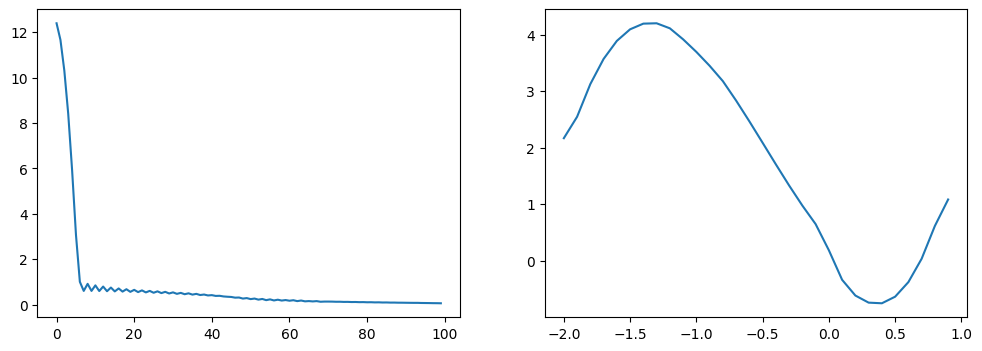

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), model.history['loss'], label='Loss')

plt.subplot(1, 2, 2)
predictions = model.predict(X_train)
plt.plot(xs, predictions)
plt.show()

### Training on Iris dataset

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target
feature_names, target_names = iris.feature_names, iris.target_names
num_classes = len(set(iris.target))
print(
    f'Training data shape: {X.shape}\n'
    f'Training labels shape: {y.shape}\n'
    f'Number of classes: {num_classes}'
)
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['target'] = df['target'].map({idx: name for idx, name in enumerate(target_names)})
df.head()

Training data shape: (150, 4)
Training labels shape: (150,)
Number of classes: 3


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_onehot = np.eye(num_classes)[y_train] # One-hot encode the target labels
print(
    f'Training data shape: {X_train.shape}\n'
    f'Training labels shape: {y_train.shape}\n'
    f'Testing data shape: {X_test.shape}\n'
    f'Testing labels shape: {y_test.shape}\n'
    f'Number of classes: {num_classes}'
)

Training data shape: (120, 4)
Training labels shape: (120,)
Testing data shape: (30, 4)
Testing labels shape: (30,)
Number of classes: 3


In [ ]:
model = Sequential([
    Dense(X_train.shape[-1], 8, activation='relu', initializer=Initializers.he_uniform, name='Dense0'),
    Dense(8, 4, activation='relu', initializer=Initializers.he_uniform, name='Dense1'),
    Dense(4, num_classes, activation='softmax', initializer=Initializers.he_uniform, name='Dense2')
])
model.summary()

           Model Summary           
┏━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer  ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Dense0 │      8       │      40 │
│ Dense1 │      4       │      36 │
│ Dense2 │      3       │      15 │
└────────┴──────────────┴─────────┘

Total params: 91

In [ ]:
epochs = 30
batch_size = 40 # Divisible by X_train size
lr_decay = WarmUpAndDecayScheduler(
    initial_learning_rate=0.1, warmup_steps=5,
    decay_steps=10, decay_rate=0.9
)
model.compile(loss=losses.categorical_crossentropy, metrics={'accuracy': metrics.accuracy})
model.train(X_train, y_train_onehot, epochs=epochs, learning_rate=lr_decay, batch_size=batch_size)

🚀 Epoch 30/30: 100%|██████████████████████████████| 3/3 [⏳00:01<00:00], loss=0.186, accuracy=0.95, learning_rate=0.0408


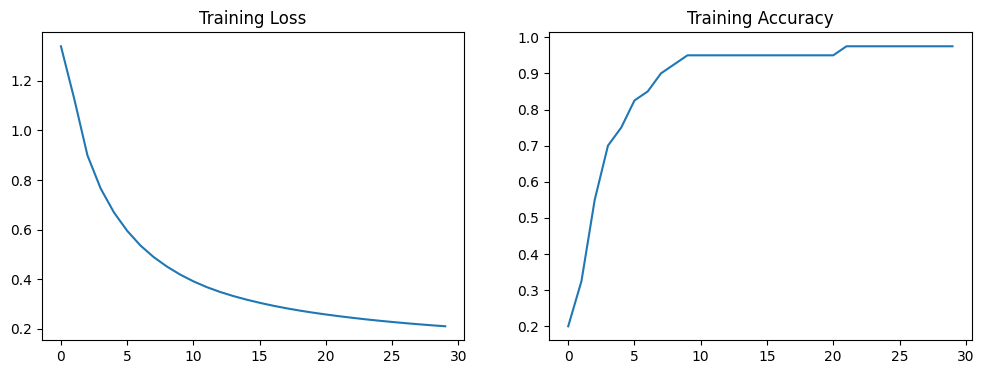

In [ ]:
steps_per_epoch = len(X_train) // batch_size
epoch_losses = [model.history['loss'][i] for i in range(0, len(model.history['loss']), steps_per_epoch)]
epoch_accuracies = [model.history['accuracy'][i] for i in range(0, len(model.history['accuracy']), steps_per_epoch)]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), epoch_losses, label='Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), epoch_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.show()

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
print('Training classification report:')
print(classification_report(y_train, y_pred_train, target_names=target_names))

Training classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        41
  versicolor       0.93      0.97      0.95        40
   virginica       0.97      0.92      0.95        39

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
print('Testing classification report:')
print(classification_report(y_test, y_pred_test, target_names=target_names))

Testing classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         9
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.82      0.90        11

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.94      0.93      0.93        30



### Training on Digits dataset

👉 I have to purchase Colab Pro to run this with more memory

In [ ]:
digits = load_digits()
X, y = digits.data, digits.target
images = digits.images
num_classes = len(set(digits.target))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24) # 24% to make the number divisible

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

print(
    f'Training data shape: {X_train.shape}\n'
    f'Training labels shape: {y_train.shape}\n'
    f'Testing data shape: {X_test.shape}\n'
    f'Testing labels shape: {y_test.shape}\n'
    f'Number of classes: {num_classes}'
)

Training data shape: (1365, 64)
Training labels shape: (1365,)
Testing data shape: (432, 64)
Testing labels shape: (432,)
Number of classes: 10


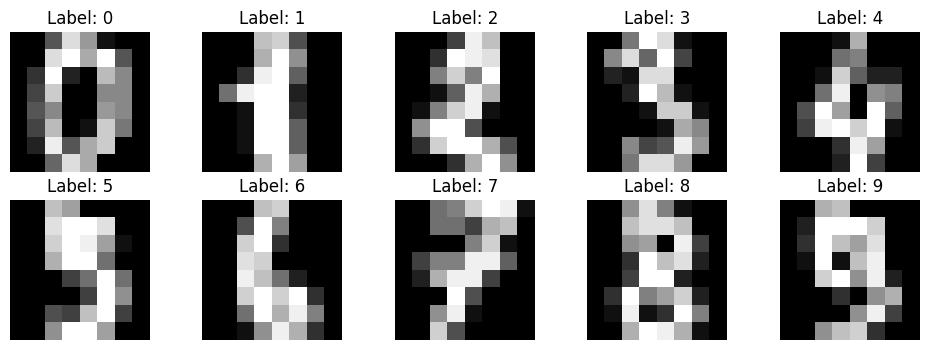

In [ ]:
plt.figure(figsize=(12, 4))
for idx, (image, label) in enumerate(zip(images[:10], y[:10])):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

In [ ]:
model = Sequential([
    Dense(X_train.shape[-1], 10, activation='relu', initializer=Initializers.he_uniform, name='Dense0'),
    Dense(10, num_classes, activation='softmax', initializer=Initializers.he_uniform, name='Dense1')
])
model.summary()

           Model Summary           
┏━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer  ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Dense0 │      10      │     650 │
│ Dense1 │      10      │     110 │
└────────┴──────────────┴─────────┘

Total params: 760

In [ ]:
epochs = 5
batch_size = 21
steps_per_epoch = len(X_train) // batch_size
lr_decay = WarmUpAndDecayScheduler(
    initial_learning_rate = 0.1,
    warmup_steps = 2 * steps_per_epoch, # 2 epochs
    decay_steps = steps_per_epoch,
    decay_rate = 0.9
)
model.compile(loss=losses.categorical_crossentropy, metrics={'accuracy': metrics.accuracy})
model.train(X_train, y_train_onehot, epochs=epochs, learning_rate=lr_decay, batch_size=batch_size)

🚀 Epoch 5/5: 100%|██████████████████████████████| 65/65 [⏳03:20<00:00], loss=0.16, accuracy=0.952, learning_rate=0.0729


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
print('Training classification report:')
print(classification_report(y_train, y_pred_train))

Training classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       139
           1       0.92      0.93      0.92       136
           2       0.94      0.98      0.96       133
           3       0.96      0.93      0.95       133
           4       0.99      0.96      0.98       140
           5       0.96      0.97      0.97       136
           6       0.98      0.99      0.99       136
           7       0.99      0.99      0.99       138
           8       0.94      0.88      0.91       136
           9       0.90      0.95      0.92       138

    accuracy                           0.96      1365
   macro avg       0.96      0.96      0.96      1365
weighted avg       0.96      0.96      0.96      1365



In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
print('Testing classification report:')
print(classification_report(y_test, y_pred_test))

Testing classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       0.92      0.96      0.94        46
           2       0.95      0.93      0.94        44
           3       0.89      0.96      0.92        50
           4       0.97      0.93      0.95        41
           5       0.98      0.93      0.96        46
           6       0.96      1.00      0.98        45
           7       0.95      1.00      0.98        41
           8       0.91      0.82      0.86        38
           9       0.86      0.86      0.86        42

    accuracy                           0.94       432
   macro avg       0.94      0.94      0.94       432
weighted avg       0.94      0.94      0.94       432

